In [2]:
import cv2
import onnxruntime as ort
import numpy as np

img = cv2.imread("test.jpg")
h0, w0 = img.shape[:2]

img_resized = cv2.resize(img, (640, 640))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_input = img_rgb.astype(np.float32) / 255.0  # (0,255) -> (0,1)
img_input = np.transpose(img_input, (2, 0, 1))  # HWC -> CHW
img_input = np.expand_dims(img_input, axis=0)   # 加上 batch 維度

# 載入模型
session = ort.InferenceSession("yolov5s.onnx")

# ONNX模型
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# 模型推論
outputs = session.run([output_name], {input_name: img_input})[0]
outputs = np.squeeze(outputs)

# 後處理
boxes, confidences, class_ids = [], [], []

#篩掉低於信心門檻的預測框
for det in outputs:
    score = det[4]
    if score < 0.4:
        continue
    # 從 80 類別裡面找出「哪一個類別信心分數最高」
    scores = det[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    
    # 再次確認「分類分數」也夠高
    if confidence > 0.4:
        cx, cy, w, h = det[:4]

        # 將模型輸出的 中心點 + 寬高 -> 換算成原圖的 左上角 + 寬高
        x = int((cx - w/2) * w0 / 640)
        y = int((cy - h/2) * h0 / 640)
        w = int(w * w0 / 640)
        h = int(h * h0 / 640)

        # 把這個預測框與其類別、信心度存起來，等等要畫出來
        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

# 非極大抑制 -> 移除重疊度太高的框，只保留分數最高者
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.5)

# 載入 coco 類別  
with open("coco.names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# 畫框與標籤
for i in indices.flatten():
    x, y, w, h = boxes[i]
    label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

cv2.imshow("YOLOv5 Detection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


2025-04-15 13:37:08.905 python[50144:8918381] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-15 13:37:08.905 python[50144:8918381] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-04-15 13:37:15.967 python[50144:8918381] _TIPropertyValueIsValid called with 16 on nil context!
2025-04-15 13:37:15.967 python[50144:8918381] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-04-15 13:37:15.967 python[50144:8918381] Text input context does not respond to _valueForTIProperty:
2025-04-15 13:37:18.799 python[50144:8918381] _TIPropertyValueIsValid called with 16 on nil context!
2025-04-15 13:37:18.799 python[50144:8918381] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-04-15 13:37:18.799 python[50144:8918381] Text input context does not respond to _valueForTIProperty:


In [5]:
import cv2
import onnxruntime as ort
import numpy as np
from collections import Counter

img = cv2.imread("test2.jpeg")
h0, w0 = img.shape[:2]

img_resized = cv2.resize(img, (640,640))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_input = img_rgb.astype(np.float32) / 255.0
img_input = np.transpose(img_input, (2, 0, 1)) 
img_input = np.expand_dims(img_input, axis=0)

session = ort.InferenceSession("yolov5s.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

outputs = session.run([output_name], {input_name : img_input})[0]
outputs = np.squeeze(outputs)

boxes , confidences, class_ids = [],[],[]

for det in outputs:
    score = det[4]
    if score < 0.4:
        continue

    scores = det[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    
    if confidence > 0.4:
        cx, cy, w, h = det[:4]

        x = int((cx - w/2) * w0 / 640)
        y = int((cy - h/2) * h0 / 640)
        w = int(w * w0 / 640)
        h = int(h * h0 / 640)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)
        
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.5)

with open("coco.names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

for i in indices.flatten():
    x, y, w, h = boxes[i]
    label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)




detected_labels = [class_names[class_ids[i]] for i in indices.flatten()]
label_counts = Counter(detected_labels)


print("實際偵測到的類別：", detected_labels)
print("模型輸出 shape :", outputs.shape)
print(f"總共偵測出 {len(detected_labels)} 個物件")
print("各類別數量：")
for label in ["person", "car", "truck", "backpack", "bicycle"]:
    print(f"  {label}: {label_counts.get(label, 0)}")

    
cv2.imshow("YOLOv5 Detection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


實際偵測到的類別： ['person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'person', 'bicycle', 'person', 'car', 'car']
模型輸出 shape : (25200, 85)
總共偵測出 14 個物件
各類別數量：
  person: 6
  car: 7
  truck: 0
  backpack: 0
  bicycle: 1


In [ ]:
import cv2
import numpy as np
import onnxruntime as ort
from collections import Counter

# === 模型 & 類別準備 ===
session = ort.InferenceSession("yolov5s.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

with open("coco.names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

cap = cv2.VideoCapture("traffic4.mp4")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    h0, w0 = frame.shape[:2]    

    # === 預處理 ===
    img_resized = cv2.resize(frame, (640,640))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_input = img_rgb.astype(np.float32) / 255.0
    img_input = np.transpose(img_input, (2,0,1))
    img_input = np.expand_dims(img_input, axis=0)

    # === 推論 ===
    outputs = session.run([output_name], {input_name: img_input})[0]
    outputs = np.squeeze(outputs)

    boxes, confidences, class_ids = [], [], []

    for det in outputs:
        score = det[4]
        if score < 0.4:
            continue

        scores = det[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.4:
            cx, cy, w, h = det[:4]
            x = int((cx - w/2) * w0 / 640)
            y = int((cy - h/2) * h0 / 640)
            w = int(w * w0 / 640)
            h = int(h * h0 / 640)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

        # === NMS + 畫框 ===
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.5)
        indices = np.array(indices).flatten()
        
        detected_labels = []

        for i in indices:
            x, y, w, h = boxes[i]
            lable = f" {class_names[class_ids[i]]} : {confidences[i]:.2f}"
            color = (0,255,0) if class_ids[i] == 0 else (255,0,0)
            cv2.rectangle(frame, (x,y), (x+w, y+h), color, 2)
            cv2.putText(frame, lable, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            detected_labels.append(class_names[class_ids[i]])

        # === 類別統計顯示 ===
        counts = Counter(detected_labels)
        y_offset = 20
        for cls in ["person", "car", "truck"]:
            count = counts.get(cls, 0)
            txt = f"{cls}: {count}"
            cv2.putText(frame, txt, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 255, 0), 2)
            y_offset += 25
          
        # === 顯示畫面 ===
        cv2.imshow("YOLOv5 - Webcam", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):  
            break
            
cap.release()
cv2.destroyAllWindows()

In [2]:
# YOLO + 分類器整合推論

import cv2
import onnxruntime as ort
import numpy as np
import os
from PIL import Image
import imagehash

# === 初始化模型 ===
session = ort.InferenceSession("yolov5s.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# === 載入類別名稱 ===
with open("coco.names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# === 建立資料夾 ===
save_root = "car_dataset/raw"
os.makedirs(save_root, exist_ok = True)

# === 讀影片 ===
cap = cv2.VideoCapture("traffic4.mp4")
frame_id = 0
crop_id = 0
prev_hash = None

fps = int(cap.get(cv2.CAP_PROP_FPS))  # 取得影片幀率
frame_interval = fps * 2

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_id += 1
    if frame_id % frame_interval != 0:
        continue

    h0, w0 = frame.shape[:2]
    img_resized = cv2.resize(frame, (640,640))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_input = img_rgb.astype(np.float32) / 255.0
    img_input = np.transpose(img_input, (2,0,1))
    img_input = np.expand_dims(img_input, axis = 0)

    outputs = session.run([output_name], {input_name : img_input})[0]
    outputs = np.squeeze(outputs)

    for det in outputs:
        score = det[4]
        if score < 0.4:
            continue
        scores = det[5:]
        class_id = np.argmax(scores)
        if class_names[class_id] not in ["car", "motorcycle"]:
            continue

        confidence = scores[class_id]
        if confidence < 0.5:
            continue
        cx, cy, w, h = det[:4]
        x = int((cx - w/2) * w0 / 640)
        y = int((cy - h/2) * h0 / 640)
        w = int(w * w0 / 640)
        h = int(h * h0 / 640)
        crop = frame[max(y,0):y+h, max(x,0):x+w]
        if crop.size == 0: continue

        # === 相似度過濾 ===
        
        crop_pil = Image.fromarray(crop) # array 轉換成 image 
        current_hash = imagehash.phash(crop_pil)
        if prev_hash is not None and abs(current_hash - prev_hash) < 5:
            continue
        prev_hash = current_hash

        save_path = os.path.join(save_root, f"car_{crop_id:04d}.jpg")
        cv2.imwrite(save_path, crop)
        crop_id += 1

    frame_id += 1

cap.release()
print(f"已裁出 {crop_id} 張車輛圖片，儲存於 {save_root}")

已裁出 2603 張車輛圖片，儲存於 car_dataset/raw


In [3]:
import os
import cv2
import shutil

input_folder = "car_dataset/raw"
output_folder = "car_dataset/cleaned"
os.makedirs(output_folder, exist_ok=True)

count = 0
seen_hashes = []

# 太模糊
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

for fname in os.listdir(input_folder):
    if not fname.lower().endswith(".jpg"):
        continue
        
    path = os.path.join(input_folder, fname)
    img = cv2.imread(path)

    # === w 或 h 小於 60px ===
    if img is None or img.shape[0] < 60 or img.shape[1] < 60:
        continue
        
    # === 平均亮度太低或太高 ===
    brightness = img.mean()
    if brightness < 35 or brightness > 225:
        continue
        
    if is_blurry(img):
        continue

    # ===== 比對 pHash 去重複 =====
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    phash = imagehash.phash(pil_img)

    is_duplicate = False
    for h in seen_hashes:
        if abs(phash - h) < 5:  # 設定相似判斷門檻
            is_duplicate = True
            break
            
    if is_duplicate:
        continue

    seen_hashes.append(phash)

    # 通過濾掉條件，保留
    shutil.copy(path, os.path.join(output_folder, fname))
    count +=1

print(f"清洗完成，有效圖片數量: {count}，儲存在：{output_folder}")

清洗完成，有效圖片數量: 734，儲存在：car_dataset/cleaned


In [4]:
# 分群
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm # 顯示進度條
import shutil

input_folder = "car_dataset/cleaned"
output_root = "car_dataset/clustered"

os.makedirs(output_root, exist_ok = True)

# 特徵提取函數
def extract_color_feature(img , bins=(8,8,8)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist,hist).flatten() #把直方圖變成「1 維向量」，可送進 KMeans
    return hist

# 初始化特徵列表、圖片路徑列表
features = []
paths = []

print("提取圖片特徵中...")
for fname in tqdm(os.listdir(input_folder)):
    path = os.path.join(input_folder, fname)
    img = cv2.imread(path)
    if img is None: 
        continue
    img = cv2.resize(img, (128,128))
    features.append(extract_color_feature(img))
    paths.append(path)

print("開始 KMeans 分群...")
k = 2
kmeans = KMeans(n_clusters = k, random_state = 42).fit(features)

for i in range(k):
    os.makedirs(os.path.join(output_root, f"group_{i}"), exist_ok = True)

for path, label in zip(paths, kmeans.labels_): #kmeans.labels_ : 是 KMeans 每張圖對應的群標籤
    dest = os.path.join(output_root, f"group_{label}", os.path.basename(path))
    shutil.copy(path, dest)
    
print(f"已自動分群至 {output_root}/group_*/ 資料夾")

提取圖片特徵中...


100%|███████████████████████████████████████| 734/734 [00:00<00:00, 5897.33it/s]

開始 KMeans 分群...


已自動分群至 car_dataset/clustered/group_*/ 資料夾


group_0:共421張


/var/folders/80/zh11mw294rddwyvtntscmqhh0000gn/T/ipykernel_50702/4103988345.py:42: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from current font.
  plt.tight_layout()
/var/folders/80/zh11mw294rddwyvtntscmqhh0000gn/T/ipykernel_50702/4103988345.py:42: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from current font.
  plt.tight_layout()
/var/folders/80/zh11mw294rddwyvtntscmqhh0000gn/T/ipykernel_50702/4103988345.py:42: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from current font.
  plt.tight_layout()
/Users/z88756212/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/z88756212/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Us

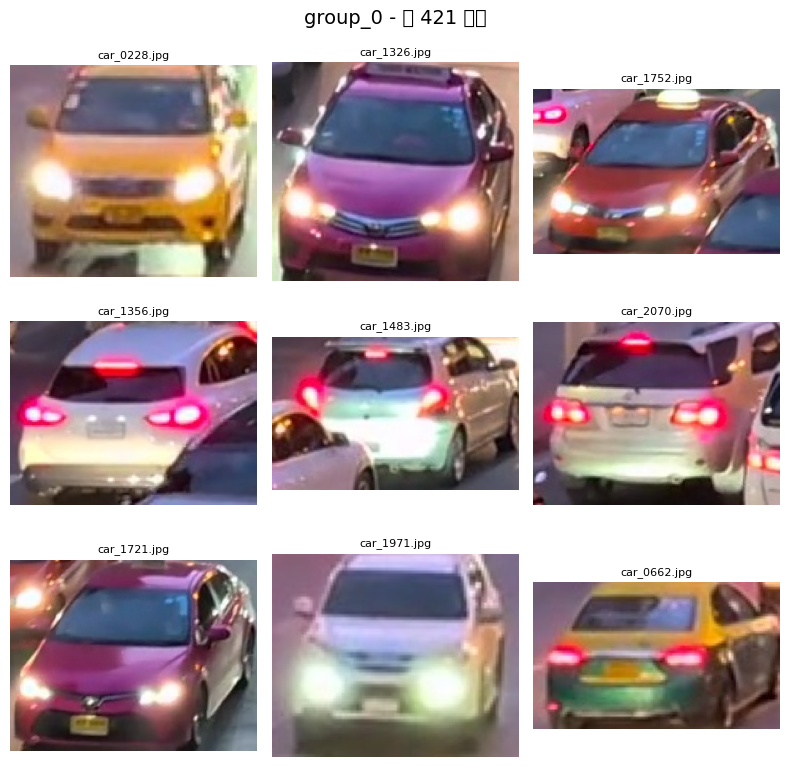

group_1:共313張


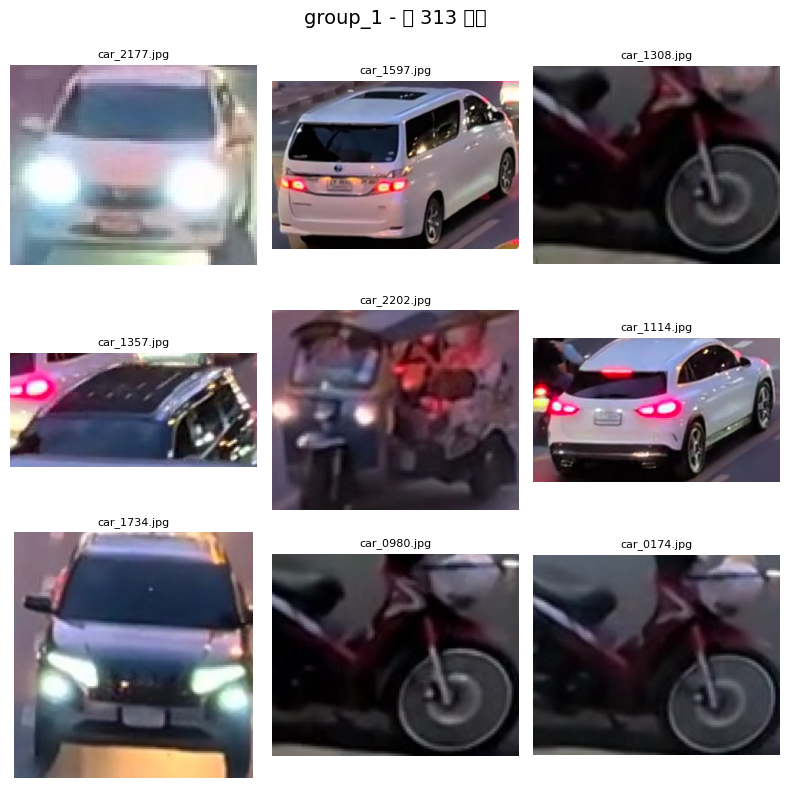

In [5]:
import os 
import cv2
import random 
import matplotlib.pyplot as plt

# === 資料夾位置 ===
root = "car_dataset/clustered"

samples_per_group = 9

# === 所有群資料夾 ===
# listdir 取得 root 資料夾下所有檔案或資料夾的名稱（只有名字，不含完整路徑）
# 針對這些名字一個一個跑迴圈，變數叫做 d
# isdir 檢查這個東西是不是一個「資料夾」而不是檔案

groups = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]
groups.sort()

for group in groups:
    group_path = os.path.join(root, group)
    all_images = [os.path.join(group_path, f) for f in os.listdir(group_path) if f.lower().endswith(".jpg")]

    print(f"{group}:共{len(all_images)}張")

    if len(all_images) == 0 :
        continue

    # 抽樣圖片
    sample_images = random.sample(all_images, min(samples_per_group, len(all_images)))

    #畫圖
    plt.figure(figsize = (8,8))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path), fontsize=8)

    plt.suptitle(f"{group} - 共 {len(all_images)} 張圖", fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
import os
import shutil

# === 來源資料夾 ===
root = "car_dataset/clustered"

rename_map = {
    "group_0" : "car",
    "group_1" : "motorcycle",
}

target_root = "car_dataset/final"
os.makedirs(target_root, exist_ok=True)

for group, new_name in rename_map.items():
    src = os.path.join(root, group)
    dst = os.path.join(target_root, new_name)
    
    if not os.path.exists(src):
        print(f"找不到 {src}，跳過")
        continue
    
    if os.path.exists(dst):
        print(f"目的資料夾 {dst} 已存在，跳過避免覆蓋")
        continue
    
    shutil.move(src, dst)
    print(f"{group} → {new_name}")

group_0 → car
group_1 → motorcycle


In [7]:
import os 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy  import Adam

data_dir = "car_dataset/final"
img_size = (128,128)
batch_size = 32
epochs = 15
 
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    validation_split=0.2
)


train_gen = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

num_classes = len(train_gen.class_indices)
class_names = list(train_gen.class_indices.keys())

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=img_size + (3,)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer= optimizer ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 588 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                        

In [8]:
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(
    train_gen,
    epochs = 20,
    validation_data = val_gen,
    callbacks=[early_stopping , lr_reduction]
)

Epoch 1/20
19/19 [==============================] - 2s 89ms/step - loss: 0.6643 - accuracy: 0.5816 - val_loss: 0.6575 - val_accuracy: 0.5753 - lr: 1.0000e-05
Epoch 2/20
19/19 [==============================] - 2s 80ms/step - loss: 0.6397 - accuracy: 0.5731 - val_loss: 0.6413 - val_accuracy: 0.5753 - lr: 1.0000e-05
Epoch 3/20
19/19 [==============================] - 2s 78ms/step - loss: 0.6330 - accuracy: 0.5782 - val_loss: 0.6387 - val_accuracy: 0.5753 - lr: 1.0000e-05
Epoch 4/20
19/19 [==============================] - 2s 82ms/step - loss: 0.6141 - accuracy: 0.5901 - val_loss: 0.6170 - val_accuracy: 0.6096 - lr: 1.0000e-05
Epoch 5/20
19/19 [==============================] - 1s 77ms/step - loss: 0.6052 - accuracy: 0.6803 - val_loss: 0.5994 - val_accuracy: 0.6370 - lr: 1.0000e-05
Epoch 6/20
19/19 [==============================] - 2s 78ms/step - loss: 0.5736 - accuracy: 0.6871 - val_loss: 0.5764 - val_accuracy: 0.6712 - lr: 1.0000e-05
Epoch 7/20
19/19 [==============================] - 

5/5 [==============================] - 0s 50ms/step


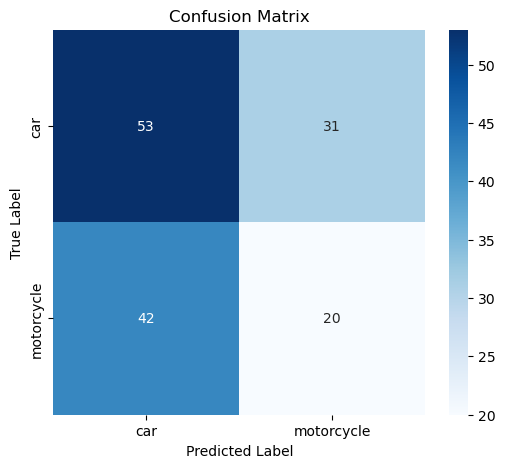

              precision    recall  f1-score   support

         car       0.56      0.63      0.59        84
  motorcycle       0.39      0.32      0.35        62

    accuracy                           0.50       146
   macro avg       0.48      0.48      0.47       146
weighted avg       0.49      0.50      0.49       146

模型已儲存：car_classifier_cnn.h5


/Users/z88756212/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis = 1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

model.save("car_classifier_cnn.h5")
print("模型已儲存：car_classifier_cnn.h5")

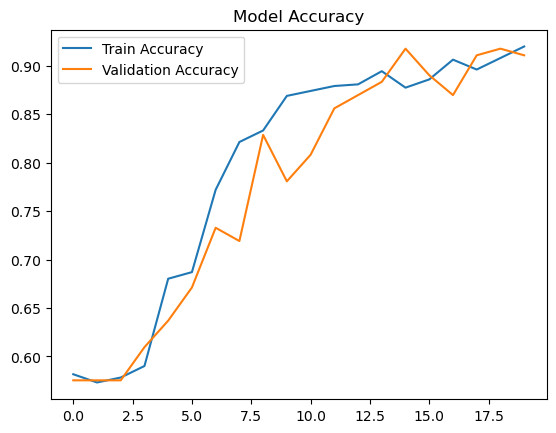

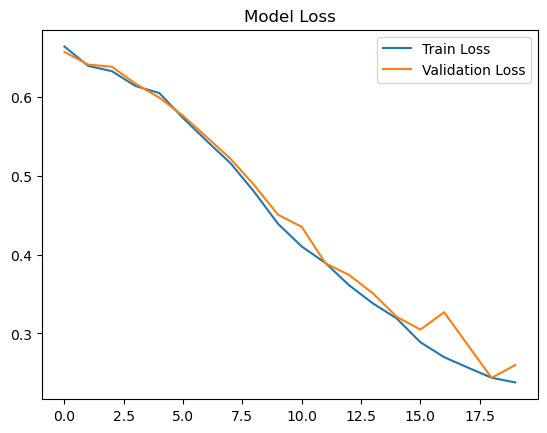

In [10]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

In [40]:
video_path = "traffic3.mp4"
save_dir = "test_dataset/raw"
os.makedirs(save_dir, exist_ok=True)

session = ort.InferenceSession("yolov5s.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


with open("coco.names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

cap = cv2.VideoCapture("traffic3.mp4")
frame_id = 0
crop_id = 0
prev_hash = None

fps = int(cap.get(cv2.CAP_PROP_FPS))  # 取得影片幀率
frame_interval = fps * 2

def is_valid_image(img):
    if img.shape[0] < 60 or img.shape[1] < 60:
        return False
    if img.mean() < 30 or img.mean() > 230:
        return False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if cv2.Laplacian(gray, cv2.CV_64F).var() < 100:
        return False
    return True

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_id += 1
    if frame_id % frame_interval != 0:
        continue

    h0, w0 = frame.shape[:2]
    img_resized= cv2.resize(frame, (640,640))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_input = img_rgb.astype(np.float32) / 255.0
    img_input = np.transpose(img_input, (2,0,1))
    img_input = np.expand_dims(img_input, axis = 0)

    outputs = session.run([output_name], {input_name : img_input})[0]
    outputs = np.squeeze(outputs)

    for det in outputs:
        score = det[4]
        if score < 0.4:
            continue
        scores = det[5:]
        class_id = np.argmax(scores)
        if class_names[class_id] not in ["car", "motorcycle"]:
            continue

        confidence = scores[class_id]
        if confidence < 0.5:
            continue
        cx, cy, w, h = det[:4]
        x = int((cx - w/2) * w0 / 640)
        y = int((cy - h/2) * h0 / 640)
        w = int(w * w0 / 640)
        h = int(h * h0 / 640)
        crop = frame[max(y,0):y+h, max(x,0):x+w]
        
        if crop.size == 0 or not is_valid_image(crop):
            continue
        
        crop_pil = Image.fromarray(crop) 
        current_hash = imagehash.phash(crop_pil)
        if prev_hash is not None and abs(current_hash - prev_hash) < 5:
            continue
        prev_hash = current_hash

        save_path = os.path.join(save_dir, f"car_{crop_id:04d}.jpg")
        cv2.imwrite(save_path, crop)
        crop_id += 1

    frame_id += 1

cap.release()
print(f"已裁出 {crop_id} 張車輛圖片，儲存於 {save_dir}")

已裁出 434 張車輛圖片，儲存於 test_dataset/raw


In [42]:
import os
import cv2
import shutil

input_folder = "test_dataset/raw"
output_folder = "test_dataset/cleaned"
os.makedirs(output_folder, exist_ok=True)

count = 0
seen_hashes = []

# 太模糊
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

for fname in os.listdir(input_folder):
    if not fname.lower().endswith(".jpg"):
        continue
        
    path = os.path.join(input_folder, fname)
    img = cv2.imread(path)

    # === w 或 h 小於 60px ===
    if img is None or img.shape[0] < 60 or img.shape[1] < 60:
        continue
        
    # === 平均亮度太低或太高 ===
    brightness = img.mean()
    if brightness < 35 or brightness > 225:
        continue
        
    if is_blurry(img):
        continue

    # ===== 比對 pHash 去重複 =====
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    phash = imagehash.phash(pil_img)

    is_duplicate = False
    for h in seen_hashes:
        if abs(phash - h) < 5:  # 設定相似判斷門檻
            is_duplicate = True
            break
            
    if is_duplicate:
        continue

    seen_hashes.append(phash)

    # 通過濾掉條件，保留
    shutil.copy(path, os.path.join(output_folder, fname))
    count +=1

print(f"清洗完成，有效圖片數量: {count}，儲存在：{output_folder}")

清洗完成，有效圖片數量: 157，儲存在：test_dataset/cleaned


Found 157 images belonging to 2 classes.
5/5 [==============================] - 0s 23ms/step

分類報告：

              precision    recall  f1-score   support

         car       1.00      0.12      0.21       139
  motorcycle       0.13      1.00      0.23        18

    accuracy                           0.22       157
   macro avg       0.56      0.56      0.22       157
weighted avg       0.90      0.22      0.21       157



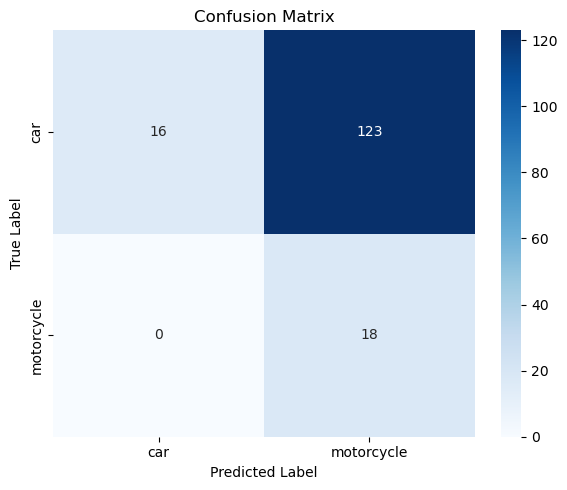

錯誤分類圖片已儲存至 `misclassified/`


In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === 參數設定 ===
model_path = "car_classifier_cnn.h5"
data_dir = "test_dataset/cleaned"
img_size = (128, 128)
batch_size = 32

# === 載入模型 ===
model = tf.keras.models.load_model(model_path)

# === 建立測試資料產生器 ===
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test_generator.class_indices.keys())

# === 預測 ===
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# === 分類報告 ===
print("\n分類報告：\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# === 混淆矩陣 ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === 儲存錯誤圖片 ===
output_dir = "misclassified"
os.makedirs(output_dir, exist_ok=True)

filenames = test_generator.filenames
for i, (truth, pred) in enumerate(zip(y_true, y_pred)):
    if truth != pred:
        src = os.path.join(data_dir, filenames[i])
        class_folder = class_names[truth]
        base = os.path.basename(filenames[i])
        dst = os.path.join(output_dir, f"{base}_pred_{class_names[pred]}.jpg")
        shutil.copy(src, dst)

print(f"錯誤分類圖片已儲存至 `{output_dir}/`")
